# Workshop.
Today we are going to create a first Deep Learning Model.
You have to select what problem do you want to solve and what type of Classification Model we will build today.

For example, I am going to build a Classification Model to classify 
*   **Pizza**
*   **Salad**
*  **Spagetti**




# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*


In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [0]:
from fastai.vision import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab/KSE/dataset"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

# Alternatives. Simple images downloading. 

We will use https://github.com/hardikvasa/google-images-download library.
Follow the instractions and install the library.


In [0]:
!pip install google_images_download

In [0]:
!googleimagesdownload -k "spagetti" --format jpg --limit 100 -o "/content/gdrive/My Drive/Colab/KSE/dataset/" -pp

In [0]:
!googleimagesdownload -k "pizza" --format jpg --limit 100 -o "/content/gdrive/My Drive/Colab/KSE/dataset/" -pp

In [0]:
!googleimagesdownload -k "salad" --format jpg --limit 100 -o "/content/gdrive/My Drive/Colab/KSE/dataset/" -pp

## View data

In [0]:
tfms = get_transforms(max_rotate=10.0, max_zoom=1.1, 
                       max_lighting=0.2, max_warp=0.2, 
                       p_affine=0.75, p_lighting=0.75)

def get_ex(): return open_image(Path(root_dir)/'salad/2. exps6498_mrr133247d07_30_5b_web-2.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) 
     for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

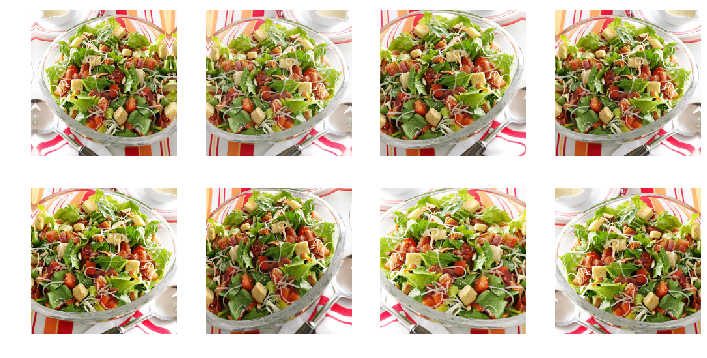

In [0]:
plots_f(2, 4, 12, 6, size=224)

In [0]:
np.random.seed(0)
data = ImageDataBunch.from_folder(path=root_dir, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
?? ImageDataBunch.from_folder

Good! Let's take a look at some of our pictures then.

In [0]:
data.classes

['pizza', 'salad', 'spagetti']

In [0]:
data.valid_ds.y

CategoryList (58 items)
salad,salad,salad,pizza,pizza
Path: /content/gdrive/My Drive/Colab/KSE/dataset

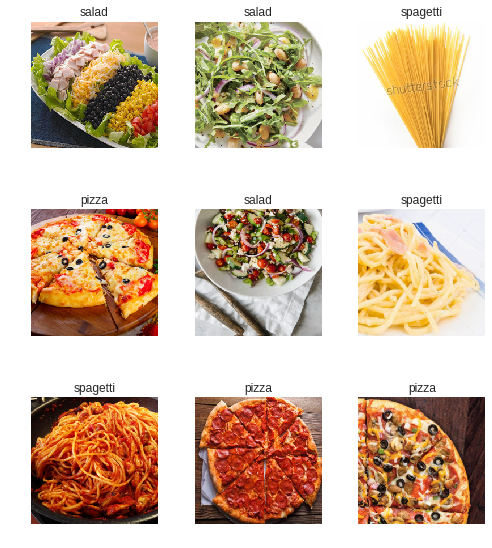

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['pizza', 'salad', 'spagetti'], 3, 233, 58)

In [0]:
data.valid_ds.y

CategoryList (58 items)
salad,salad,salad,pizza,pizza
Path: /content/gdrive/My Drive/Colab/KSE/dataset

## Train model

In [0]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [0]:
learn.fit_one_cycle(5, max_lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
1,1.434264,0.984611,0.500000,00:20
2,1.201786,0.576996,0.844828,00:20
3,0.973259,0.359784,0.862069,00:20
4,0.804802,0.275559,0.931035,00:20
5,0.686837,0.245949,0.948276,00:20


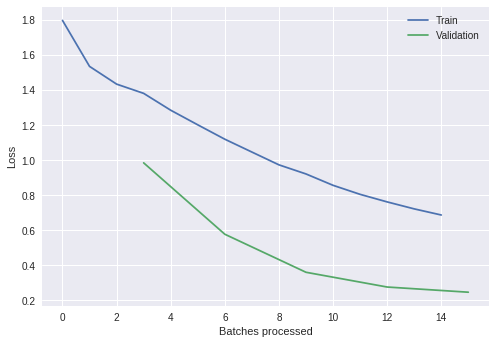

In [0]:
learn.recorder.plot_losses()

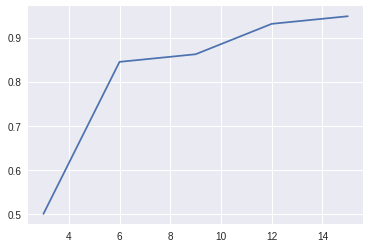

In [0]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, max_lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
1,0.164320,0.099506,0.965517,00:21
2,0.089743,0.159182,0.982759,00:20
3,0.065265,0.351407,0.948276,00:21
4,0.061510,0.616217,0.896552,00:21
5,0.051602,0.415700,0.931035,00:21


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-1');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

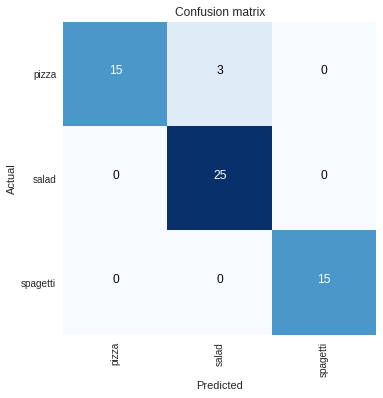

In [0]:
interp.plot_confusion_matrix()

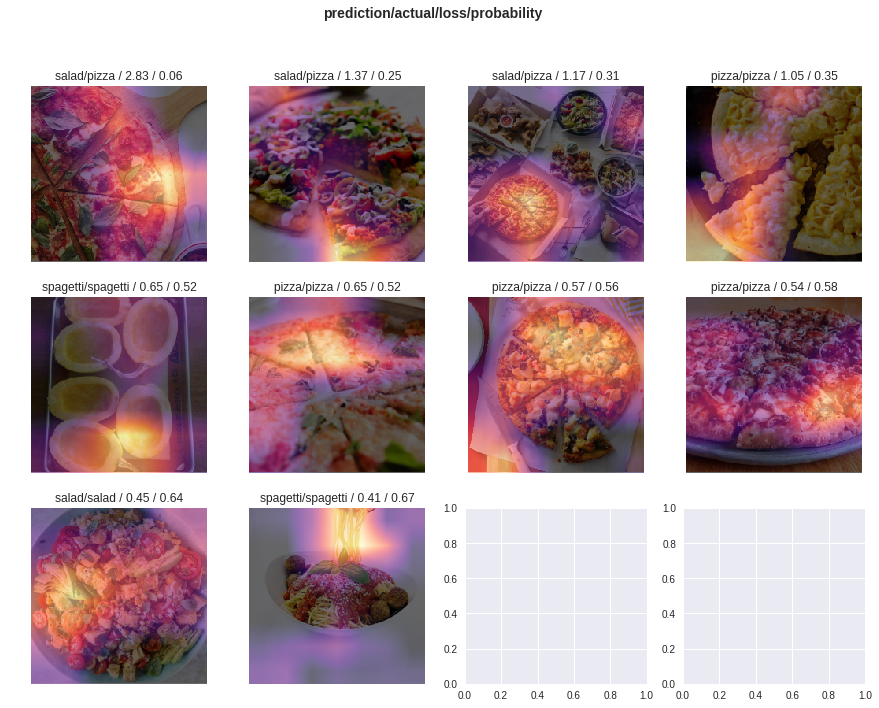

In [0]:
interp.plot_top_losses(10, figsize=(15,11))

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [0]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

ImageCleaner(ds, idxs, Path(root_dir))

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [0]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



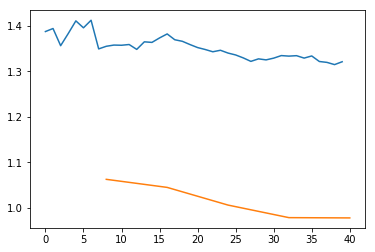

In [0]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [0]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [0]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2